In [124]:
#v3.classification
#28/11/2018

dataname="lymphoma"
gpuid=2

# --- densenet params
#these parameters get fed directly into the densenet class, and more description of them can be discovered there
n_classes= 3    #number of classes in the data mask that we'll aim to predict
in_channels= 3  #input channel of the data, RGB = 3


growth_rate=32 
block_config=(2, 2, 2, 2)
num_init_features=64
bn_size=4
drop_rate=0
num_classes=3


# --- training params
batch_size=128
patch_size=224 #currently, this needs to be 224 due to densenet architecture
num_epochs = 100
phases = ["train","val"] #how many phases did we create databases for?
validation_phases= ["val"] #when should we do valiation? note that validation is *very* time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch
                           #additionally, using simply [], will skip validation entirely, drastically speeding things up

In [125]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import DenseNet

import PIL
import matplotlib.pyplot as plt
import cv2

import numpy as np
import sys, glob

from tensorboardX import SummaryWriter

import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix

In [126]:
#helper function for pretty printing of current time and remaining time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [127]:
#specify if we should use a GPU (cuda) or only the CPU
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='GeForce GTX TITAN X', major=5, minor=2, total_memory=12207MB, multi_processor_count=24)


In [128]:
#build the model according to the paramters specified above and copy it to the GPU. finally print out the number of trainable parameters
 
model = DenseNet(growth_rate=growth_rate, block_config=block_config,
                 num_init_features=num_init_features, bn_size=bn_size, drop_rate=drop_rate, num_classes=num_classes).to(device)
#model = DenseNet(growth_rate=32, block_config=(6, 12, 24, 16), #these represent the default parameters
#                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=3)

print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

total params: 	415683


In [129]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,img_transform=None):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname

        self.img_transform=img_transform
        
        with tables.open_file(self.fname,'r') as db:
            self.classsizes=db.root.classsizes[:]
            self.nitems=db.root.imgs.shape[0]
        
        self.imgs = None
        self.labels = None
        
    def __getitem__(self, index):
        #opening should be done in __init__ but seems to be
        #an issue with multithreading so doing here. need to do it everytime, otherwise hdf5 crashes

        with tables.open_file(self.fname,'r') as db:
            self.imgs=db.root.imgs
            self.labels=db.root.labels

            #get the requested image and mask from the pytable
            img = self.imgs[index,:,:,:]
            label = self.labels[index]
        
        
        img_new = img
        
        if self.img_transform is not None:
            img_new = self.img_transform(img)


        return img_new, label, img
    def __len__(self):
        return self.nitems

In [130]:
img_transform = transforms.Compose([
     transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), 
    transforms.RandomResizedCrop(size=patch_size),
    transforms.RandomRotation(180),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=.5),
    transforms.RandomGrayscale(),
    transforms.ToTensor()
    ])


dataset={}
dataLoader={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    
    dataset[phase]=Dataset(f"./{dataname}_{phase}.pytable", img_transform=img_transform)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=8,pin_memory=True) 
    print(f"{phase} dataset size:\t{len(dataset[phase])}")



train dataset size:	10080
val dataset size:	1140


1


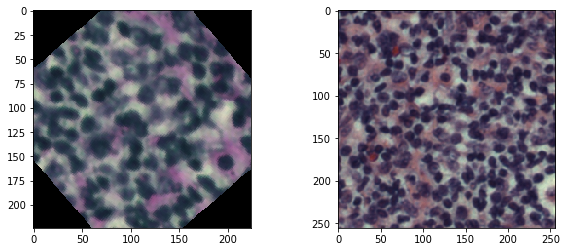

In [131]:
#visualize a single example to verify that it is correct
(img, label, img_old)=dataset["train"][7]
fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

#build output showing patch after augmentation and original patch
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(img_old)

print(label)

In [132]:
optim = torch.optim.Adam(model.parameters()) #adam is going to be the most robust, though perhaps not the best performing, typically a good place to start
# optim = torch.optim.SGD(model.parameters(),
#                           lr=.1,
#                           momentum=0.9,
#                           weight_decay=0.0005)

In [133]:
#we have the ability to weight individual classes, in this case we'll do so based on their presense in the trainingset
#to avoid biasing any particular class
nclasses = dataset["train"].classsizes.shape[0]
class_weight=dataset["train"].classsizes
class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)

print(class_weight) #show final used weights, make sure that they're reasonable before continouing
criterion = nn.CrossEntropyLoss(weight = class_weight) 


tensor([0.6994, 0.6250, 0.6756], device='cuda:2')


In [134]:
#def trainnetwork():
    writer=SummaryWriter() #open the tensorboard visualiser
    best_loss_on_test = np.Infinity

    start_time = time.time()
    for epoch in range(num_epochs):
        #zero out epoch based performance variables 
        all_acc = {key: 0 for key in phases} 
        all_loss = {key: torch.zeros(0).to(device) for key in phases} #keep this on GPU for greatly improved performance
        cmatrix = {key: np.zeros((n_classes,n_classes)) for key in phases}

        for phase in phases: #iterate through both training and validation states

            if phase == 'train':
                model.train()  # Set model to training mode
            else: #when in eval mode, we don't want parameters to be updated
                model.eval()   # Set model to evaluate mode

            for ii , (X, label, img_orig) in enumerate(dataLoader[phase]): #for each of the batches
                X = X.to(device)  # [Nbatch, 3, H, W]
                label = label.type('torch.LongTensor').to(device)  # [Nbatch, 1] with class indices (0, 1, 2,...n_classes)

                with torch.set_grad_enabled(phase == 'train'): #dynamically set gradient computation, in case of validation, this isn't needed
                                                                #disabling is good practice and improves inference time

                    prediction = model(X)  # [N, Nclass]
                    loss = criterion(prediction, label)


                    if phase=="train": #in case we're in train mode, need to do back propogation
                        optim.zero_grad()
                        loss.backward()
                        optim.step()
                        train_loss = loss


                    all_loss[phase]=torch.cat((all_loss[phase],loss.detach().view(1,-1)))

                    if phase in validation_phases: #if this phase is part of validation, compute confusion matrix
                        p=prediction.detach().cpu().numpy()
                        cpredflat=np.argmax(p,axis=1).flatten()
                        yflat=label.cpu().numpy().flatten()

                        cmatrix[phase]=cmatrix[phase]+confusion_matrix(yflat,cpredflat, labels=range(nclasses))

            all_acc[phase]=(cmatrix[phase]/cmatrix[phase].sum()).trace()
            all_loss[phase] = all_loss[phase].cpu().numpy().mean()

            #save metrics to tensorboard
            writer.add_scalar(f'{phase}/loss', all_loss[phase], epoch)
            if phase in validation_phases:
                writer.add_scalar(f'{phase}/acc', all_acc[phase], epoch)
                for r in range(nclasses):
                    for c in range(nclasses): #essentially write out confusion matrix
                        writer.add_scalar(f'{phase}/{r}{c}', cmatrix[phase][r][c],epoch)

        print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
                                                     epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")    

        #if current loss is the best we've seen, save model state with all variables
        #necessary for recreation
        if all_loss["val"] < best_loss_on_test:
            best_loss_on_test = all_loss["val"]
            print("  **")
            state = {'epoch': epoch + 1,
             'model_dict': model.state_dict(),
             'optim_dict': optim.state_dict(),
             'best_loss_on_test': all_loss,
             'n_classes': n_classes,
             'in_channels': in_channels,
             'growth_rate':growth_rate,
             'block_config':block_config,
             'num_init_features':num_init_features,
             'bn_size':bn_size,
             'drop_rate':drop_rate,
             'num_classes':num_classes}


            torch.save(state, f"{dataname}_densenet_best_model.pth")
        else:
            print("")


/mnt/data/home/axj232/classification_lymphoma_densenet/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


0m 26s (- 43m 55s) ([1/100] 1%), train loss: 0.8969 test loss: 0.9488  **
0m 53s (- 43m 25s) ([2/100] 2%), train loss: 0.8279 test loss: 0.9517
1m 20s (- 43m 18s) ([3/100] 3%), train loss: 0.7735 test loss: 0.8768  **
1m 47s (- 43m 0s) ([4/100] 4%), train loss: 0.7345 test loss: 0.8993
2m 15s (- 42m 45s) ([5/100] 5%), train loss: 0.6855 test loss: 0.7753  **
2m 43s (- 42m 34s) ([6/100] 6%), train loss: 0.6552 test loss: 0.7732  **
3m 10s (- 42m 7s) ([7/100] 7%), train loss: 0.6020 test loss: 1.1655
3m 37s (- 41m 40s) ([8/100] 8%), train loss: 0.5848 test loss: 0.5973  **
4m 5s (- 41m 20s) ([9/100] 9%), train loss: 0.5416 test loss: 0.9699
4m 32s (- 40m 54s) ([10/100] 10%), train loss: 0.5215 test loss: 0.8378
5m 0s (- 40m 31s) ([11/100] 11%), train loss: 0.5119 test loss: 0.8150
5m 28s (- 40m 7s) ([12/100] 12%), train loss: 0.4998 test loss: 0.5695  **
5m 55s (- 39m 41s) ([13/100] 13%), train loss: 0.4901 test loss: 0.9899
6m 23s (- 39m 15s) ([14/100] 14%), train loss: 0.4720 test loss

In [123]:
#%load_ext line_profiler
#%lprun -f trainnetwork trainnetwork()

/mnt/data/home/axj232/classification_lymphoma_densenet/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


0m 28s (- 0m 28s) ([1/2] 50%), train loss: 0.5181 test loss: 0.5673  **
0m 57s (- -1m 59s) ([2/2] 100%), train loss: 0.5002 test loss: 0.9277


In [ ]:
#At this stage, training is done...below are snippets to help with other tasks: output generation + visualization 

In [135]:
#----- generate output
#load best model
checkpoint = torch.load(f"{dataname}_densenet_best_model.pth")
model.load_state_dict(checkpoint["model_dict"])

In [136]:
#grab a single image from validation set
(img, label, img_old)=dataset["val"][2]

In [137]:
#generate its output
#%%timeit
output=model(img[None,::].to(device))
output=output.detach().squeeze().cpu().numpy()
output.shape

(3,)

In [138]:
print(output)
print(f"True class:{label}")
print(f"Predicted class:{np.argmax(output)}")

[  0.53497875 -11.743829     4.3187046 ]
True class:2
Predicted class:2


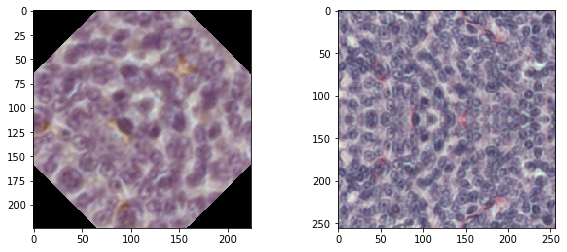

In [139]:
#look at input
fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(img_old)

In [140]:
#------- visualize kernels and activations

In [141]:
#helper function for visualization
def plot_kernels(tensor, num_cols=8 ,cmap="gray"):
    if not len(tensor.shape)==4:
        raise Exception("assumes a 4D tensor")
#    if not tensor.shape[1]==3:
#        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0] * tensor.shape[1]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    i=0
    t=tensor.data.numpy()
    for t1 in t:
        for t2 in t1:
            i+=1
            ax1 = fig.add_subplot(num_rows,num_cols,i)
            ax1.imshow(t2 , cmap=cmap)
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [142]:
class LayerActivations():
    features=None
    def __init__(self,layer):
        self.hook = layer.register_forward_hook(self.hook_fn)
    def hook_fn(self,module,input,output):
        self.features = output.cpu()
    def remove(self):
        self.hook.remove()

In [143]:
# --- visualize kernels

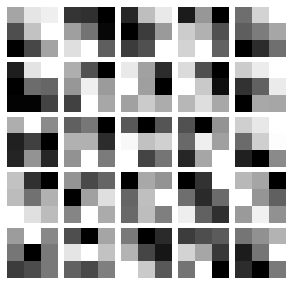

In [144]:
w=model.features.denseblock2.denselayer1.conv2
plot_kernels(w.weight.detach().cpu()[0:5,0:5,:,:],5)

In [145]:
# ---- visualize activiations

In [146]:
dr=LayerActivations(model.features.denseblock2.denselayer1.conv2)

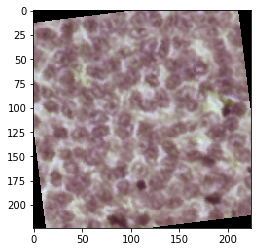

In [147]:
(img, label, img_old)=dataset["val"][7]
plt.imshow(np.moveaxis(img.numpy(),0,-1))
output=model(img[None,::].to(device))

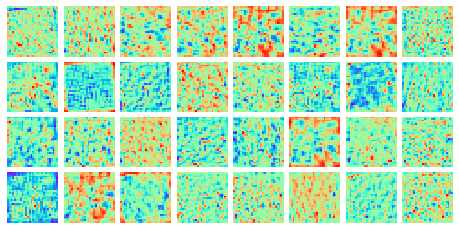

In [148]:
plot_kernels(dr.features,8,cmap="rainbow")

In [149]:
## ---- Improvements:
#1 replace Adam with SGD with appropriate learning rate reduction
